# Trabajo Final - Grupo 1 
Integrantes: Keyth Hurtado, Fátima Trujillo y Melani Geng

In [14]:
#Importamos las librerías que usaremos a lo largo del trabajo

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm

## 2. Web Scrapping
En esta sección realizamos la extracción del historial de elecciones de Venezuela (data entre 2000-2015). La información es extraída del siguiente sitio: [venezuela360.org](https://venezuela360.org/arcgis/apps/sites/#/infraestructura-geoespacial/datasets/3d0308d198ba422fbdabd2e1859eb577/data?geometry=-87.355%2C-0.931%2C-46.003%2C14.299)

In [2]:
#Primero importamos las librerías necesarias para el web scrapping 
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import Select  # selccionar opciones de las lista desplegable
from selenium.webdriver.common.by import By  # permite seleccionar los elementos en un html
from selenium.webdriver.common.keys import Keys  # ingresar datos a un formulario
from selenium.common.exceptions import NoSuchElementException
# Opciones driver
from selenium.webdriver.chrome.options import Options
from tqdm import tqdm # contabilizar tiempo en el loop
import html5lib #Leer la tabla en html
import time  # control del tiempo 
from urllib.parse import urlparse, parse_qs #para encontrar la última página

In [3]:
#Indicamos el url de la página a utilizar
url='https://venezuela360.org/arcgis/apps/sites/#/infraestructura-geoespacial/datasets/3d0308d198ba422fbdabd2e1859eb577/data'

#abrimos la página
driver = webdriver.Chrome("chromedriver.exe")
driver.maximize_window()
driver.get(url)

time.sleep(10)

C:\Users\Melani\AppData\Local\Temp\ipykernel_18412\2490142730.py:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("chromedriver.exe")


In [4]:
#Definimos el XPath de los elementos que nos interesan:
xpath_next='//a[contains(@aria-label, "Siguiente")]' #Path del botón siguiente
xpath_div='//*[@id="ember114"]/div[4]' #Path de la división que contiene a la tabla



In [5]:
#Extraemos la tabla de la primera página
table_html=driver.find_element(By.XPATH, xpath_div).get_attribute('innerHTML')
table_html

'\n  <table class="table table-striped table-bordered table-hover" role="grid">\n    <thead role="rowgroup">\n      <tr role="row">\n          <th id="ember117" class="ember-view"><button style="touch-action: manipulation; -ms-touch-action: manipulation; cursor: pointer;" aria-labelledby="ember117" aria-label="Filtrar" id="ember118" class="btn btn-link btn ember-view" type="button">  <svg class="">\n    <title></title>\n    <use xlink:href="#ember-arcgis-hub-components-hub-icons-filter"></use>\n  </svg>\n<!---->\n</button>\n\n<span class="sort-data" tabindex="0" role="button" aria-controls="ember117-sort-icon" aria-describedby="tooltip_oxgphazsue" data-ember-action="" data-ember-action-119="119">\n  <span id="ember120" class="hub-tooltip__target"><!----></span>\n  <span id="ember117">Abstencion2000</span>\n</span>\n\n<!----><div class="hub-tooltip" role="tooltip" id="tooltip_oxgphazsue" aria-hidden="true" x-placement="top" x-out-of-boundaries="" style="position: fixed; visibility: hidd

In [6]:
#Transformamos la tabla en HTML a una dataframe 
table = pd.read_html(table_html)
table[0]

,Abstencion2000,Abstencion2001,Abstencion2006,Abstencion2007,Abstencion2008,Abstencion2009,Abstencion2010,Abstencion2012,Abstencion2013,Abstencion2015,...,Votos2008,Votos2009,Votos2010,Votos2012,Votos2013,Votos2015,win2006,Winner2006,winnerSwing,OBJECTID1
0,0,927,650,965,999,660,821,474,497,521,...,1349,1679,1437,1723,1700,1522,563,Oficialismo,Unidad,1
1,0,1144,546,891,1060,773,1195,617,645,728,...,1431,1690,1571,1996,1968,1570,95,Oficialismo,Unidad,2
2,0,1217,650,878,1015,743,853,599,664,850,...,1379,1623,1526,2013,1948,1835,76,Oficialismo,Unidad,3
3,0,1556,512,718,792,505,619,951,978,1035,...,973,1251,1117,1990,1963,1815,313,Oficialismo,Unidad,4
4,0,1904,867,1254,1579,995,1266,854,907,1435,...,3354,3815,3945,4439,4386,4094,-1431,Unidad,Unidad,5
5,0,307,129,193,238,151,201,151,155,235,...,565,639,708,800,796,782,-206,Unidad,Unidad,6
6,0,547,416,590,596,457,477,332,345,439,...,1134,1246,1141,1177,1164,1008,-634,Unidad,Unidad,7
7,0,2065,829,1282,1476,956,1217,920,1030,1366,...,2906,3356,3220,4172,4062,3540,-1011,Unidad,Unidad,8
8,0,130,58,110,137,97,114,64,68,85,...,188,226,210,264,260,227,175,Oficialismo,Unidad,9
9,0,818,400,563,664,416,523,386,410,599,...,1671,1882,1925,2171,2147,2003,-767,Unidad,Unidad,10


Se puede ver que se ha extraído exitosamente la tabla de la primera página. A continuación, extraeremos las demás páginas y las compilaremos en una única tabla.

In [7]:
#Averiguamos el número de páginas
xpath_inicio='//*[@id="ember114"]/nav/ul/li[1]/a'
driver.find_element(By.XPATH,xpath_inicio).click() #Regresamos a la primera página
xpath_final='//*[@id="ember114"]/nav/ul/li[14]/a' #Path del botón que nos lleva a la última página del sitio
driver.find_element(By.XPATH,xpath_final).click()
driver.find_element(By.XPATH, '//*[@id="ember114"]/nav/ul/li[8]/a').text

'1319'

In [8]:
#Regresamos a la primera página
xpath_inicio='//*[@id="ember114"]/nav/ul/li[1]/a'
driver.find_element(By.XPATH,xpath_inicio).click()

#Código para hacer click en la siguiente página
driver.find_element(By.XPATH,xpath_next).click()
time.sleep(1)

In [9]:
#Corremos un loop para extraer todas las tablas
driver.find_element(By.XPATH,xpath_inicio).click()
all_tables={}
for i in tqdm(range(1319)):
    if i<=1317:
        table_html=driver.find_element(By.XPATH, xpath_div).get_attribute('innerHTML')
        table = pd.read_html(table_html)
        table = table[0]
        all_tables[f"table_page_{i}"] = table  # llena el diccionario 
        driver.find_element(By.XPATH,xpath_next).click()
    elif i>1317: #Se ha incluido esta condición pues la última página no contiene el botón 'Siguiente'
        table_html=driver.find_element(By.XPATH, xpath_div).get_attribute('innerHTML')
        table = pd.read_html(table_html)
        table = table[0]
        all_tables[f"table_page_{i}"] = table  # llena el diccionario 

        
    
  

100%|██████████████████████████████████████████████████████████████████████████████| 1319/1319 [05:55<00:00,  3.71it/s]


In [10]:
#Se puede ver que se han extraído todas las tablas 
all_tables.keys()

dict_keys(['table_page_0', 'table_page_1', 'table_page_2', 'table_page_3', 'table_page_4', 'table_page_5', 'table_page_6', 'table_page_7', 'table_page_8', 'table_page_9', 'table_page_10', 'table_page_11', 'table_page_12', 'table_page_13', 'table_page_14', 'table_page_15', 'table_page_16', 'table_page_17', 'table_page_18', 'table_page_19', 'table_page_20', 'table_page_21', 'table_page_22', 'table_page_23', 'table_page_24', 'table_page_25', 'table_page_26', 'table_page_27', 'table_page_28', 'table_page_29', 'table_page_30', 'table_page_31', 'table_page_32', 'table_page_33', 'table_page_34', 'table_page_35', 'table_page_36', 'table_page_37', 'table_page_38', 'table_page_39', 'table_page_40', 'table_page_41', 'table_page_42', 'table_page_43', 'table_page_44', 'table_page_45', 'table_page_46', 'table_page_47', 'table_page_48', 'table_page_49', 'table_page_50', 'table_page_51', 'table_page_52', 'table_page_53', 'table_page_54', 'table_page_55', 'table_page_56', 'table_page_57', 'table_page_5

In [11]:
#Concatenamos las tablas
votacion_data = pd.concat( all_tables.values() ).reset_index( drop = True )
votacion_data

,Abstencion2000,Abstencion2001,Abstencion2006,Abstencion2007,Abstencion2008,Abstencion2009,Abstencion2010,Abstencion2012,Abstencion2013,Abstencion2015,...,Votos2008,Votos2009,Votos2010,Votos2012,Votos2013,Votos2015,win2006,Winner2006,winnerSwing,OBJECTID1
0,0,927,650,965,999,660,821,474,497,521,...,1349,1679,1437,1723,1700,1522,563.0,Oficialismo,Unidad,1
1,0,1144,546,891,1060,773,1195,617,645,728,...,1431,1690,1571,1996,1968,1570,95.0,Oficialismo,Unidad,2
2,0,1217,650,878,1015,743,853,599,664,850,...,1379,1623,1526,2013,1948,1835,76.0,Oficialismo,Unidad,3
3,0,1556,512,718,792,505,619,951,978,1035,...,973,1251,1117,1990,1963,1815,313.0,Oficialismo,Unidad,4
4,0,1904,867,1254,1579,995,1266,854,907,1435,...,3354,3815,3945,4439,4386,4094,-1431.0,Unidad,Unidad,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13178,403,383,225,315,314,247,279,220,210,282,...,760,820,904,1012,1022,1023,NaN,NaN,Unidad,13169
13179,1354,1185,797,1267,1072,988,1036,686,706,825,...,2954,3025,2759,2984,2964,2660,NaN,NaN,Unidad,13170
13180,473,445,253,354,329,315,372,236,240,315,...,1005,1006,1048,1195,1191,1135,NaN,NaN,Unidad,13181
13181,1167,1000,897,1493,1023,894,976,559,534,691,...,3363,3476,3061,2848,2873,2689,NaN,NaN,Unidad,13182


In [12]:
#Finalmente cerramos el driver abierto
driver.quit()  

In [13]:
#Esportamos la tabla en excel
votacion_data.to_excel(r'votacion_data.xlsx', index=False)

## 3. Mapas
En esta sección se busca replicar dos figuras del paper Land Reform and Civil Conflict: Theory and Evidence from Peru de Michael Albertus.

In [15]:
# Leemos la base de distritos

distritos = gpd.read_file("../../data/trabajo_final/MAPAS/districts_1975_remake.shp")
distritos = distritos.to_crs("EPSG:32618") #Ajustamos la codificación

#Obtenemos los centroides, y sus respectivos longitud y latitud
distritos['centroide'] = distritos['geometry'].centroid

distritos['longitud'] = distritos['centroide'].x
distritos['latitud'] = distritos['centroide'].y


In [16]:
# Leemos la base de departamentos

departamentos = gpd.read_file("../../data/trabajo_final/MAPAS/department_peru.shp")
departamentos = departamentos.to_crs("EPSG:32618") #Ajustamos la codificación

#Obtenemos los centroides, y sus respectivos longitud y latitud
departamentos['centroid'] = departamentos['geometry'].centroid

departamentos['longitude'] = departamentos['centroid'].x
departamentos['latitude'] = departamentos['centroid'].y

In [17]:
# Leemos los archivos de las capas Agrarian Core Zone y Agrarian Zone

agrarian_core = gpd.read_file("../../data/trabajo_final/MAPAS/Figure1Geodatabase.gdb", layer='agrozone_core2_polygons')
agrarian_zone = gpd.read_file("../../data/trabajo_final/MAPAS/Figure1Geodatabase.gdb", layer='agrarian_zones_polygons')

#Ajustamos la codificación
agrarian_core = agrarian_core.to_crs("EPSG:32618")
agrarian_zone = agrarian_zone.to_crs("EPSG:32618")

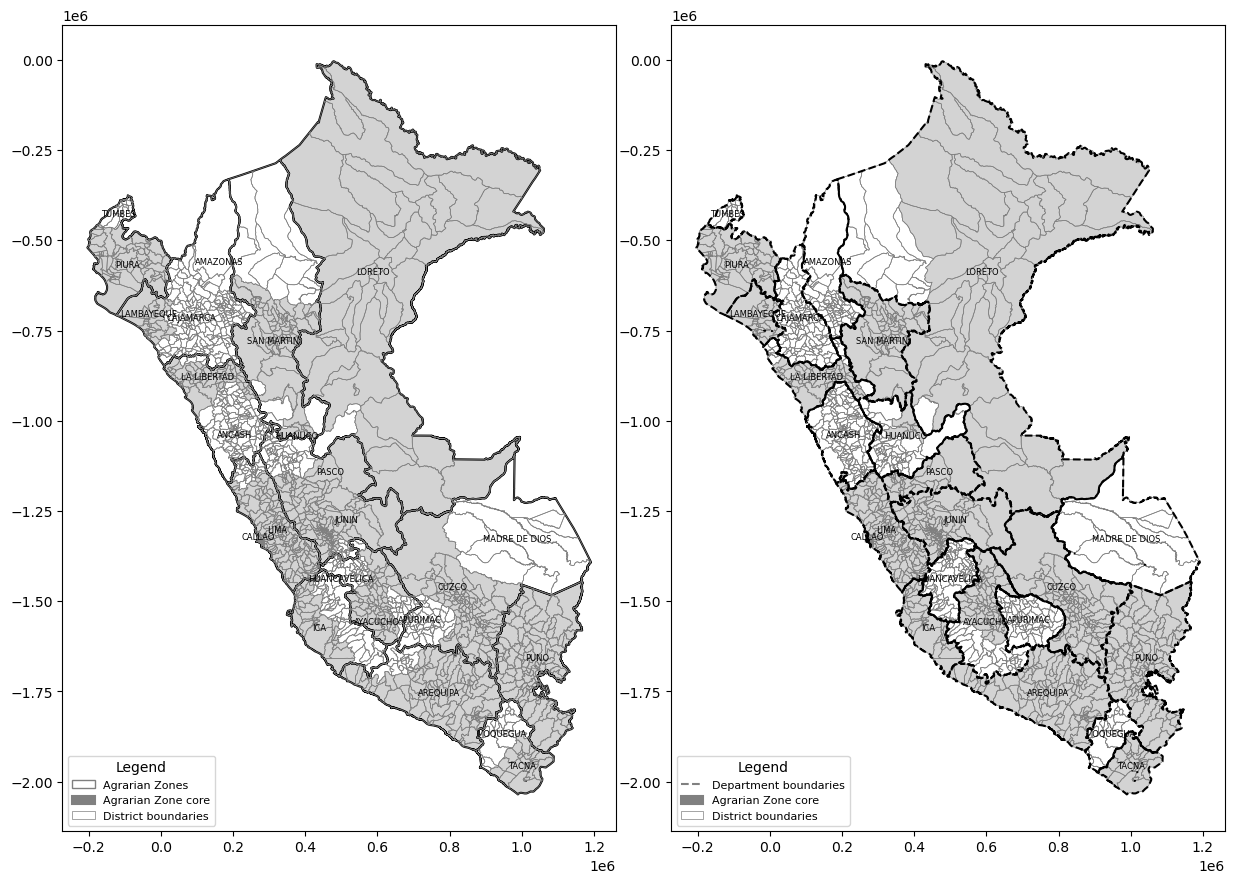

In [18]:
#Figura 1

#Creamos el objeto de la figura y especificamos el número de filas y columnas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

#Incluimos el eje y las capas de la figura de la izquierda (Figura 1.1)
axes[0].set_aspect('equal')
agrarian_core.plot(ax=axes[0], color='darkgray', edgecolor='none', alpha=0.5)
agrarian_zone.plot(ax=axes[0], color='none', edgecolor='black', linewidth=1.5)
distritos.boundary.plot(ax=axes[0], color='gray', edgecolor='gray', linewidth=0.5)

# Creamos objetos Patch para la leyenda de la Figura 1.1
patch1 = mpatches.Patch(facecolor='white', edgecolor='black', alpha=0.5, label='Agrarian Zones')
patch2 = mpatches.Patch(facecolor='gray', edgecolor='gray', linewidth=1.5, label='Agrarian Zone core')
patch3 = mpatches.Patch(facecolor='white', edgecolor='gray', linewidth=0.5, label='District boundaries')

#Hacemos un loop para incorporar los nombres de los departamentos dentro del mapa
for x, y, label in zip(departamentos['longitude'], departamentos['latitude'], departamentos['DN93']):
    axes[0].text(x, y, label, fontsize=6, ha='center', va='center')

# Añadimos leyenda con los objetos Patch a la Figura 1.1
axes[0].legend(handles=[patch1, patch2, patch3], loc='lower left', fontsize=8, title="Legend")

#Incluimos el eje y las capas de la Figura 1.2
axes[1].set_aspect('equal')
agrarian_core.plot(ax=axes[1], color='darkgray', edgecolor='none', alpha=0.5)
distritos.boundary.plot(ax=axes[1], color='gray', edgecolor='gray', linewidth=0.5)
departamentos.boundary.plot(ax=axes[1], color='black', edgecolor='black', linestyle='dashed', linewidth=1.5)

#Hacemos un loop para incorporar los nombres de los departamentos dentro del mapa
for x, y, label in zip(departamentos['longitude'], departamentos['latitude'], departamentos['DN93']):
    axes[1].text(x, y, label, fontsize=6, ha='center', va='center')

# Creamos un objeto Line2D para la línea rayada en la leyenda de la Figura 1.2
line1 = mlines.Line2D([], [], color='gray', linestyle='dashed', linewidth=1.5, label='Department boundaries')

# Añadimos la leyenda con los objetos Patch y Line2D a la Figura 1.2
axes[1].legend(handles=[line1, patch2, patch3], loc='lower left', fontsize=8, title="Legend")

plt.subplots_adjust(wspace=0.1)  # Ajustamos el espaciado horizontal entre los subplots

#Mostamos la figura
plt.show()

In [8]:
#Insumos para la figura 2

# Leemos los archivos de eventos y tierras
eventos = pd.read_csv("../../data/trabajo_final/MAPAS/PeruLR_1975shapedata.csv")

#Voldemos a leer los archivos de distritos y departamentos
distritos = gpd.read_file("../../data/trabajo_final/MAPAS/districts_1975_remake.shp")
distritos = distritos.to_crs("EPSG:32618")

departamentos = gpd.read_file("../../data/trabajo_final/MAPAS/department_peru.shp")
departamentos = departamentos.to_crs("EPSG:32618")

# Transformamos los datos de la base eventos
eventos['tierras'] = np.log(1 + 100 * eventos['mEE_DR_13_1980_pcSupM_adj'])
eventos['violencia'] = np.log(1 + eventos['totalevents'])
eventos['ubi12'] = eventos['ubi12'].astype(str).str.zfill(6) #Ajustamos ubi12 para hacer el merge
eventos = eventos[eventos['name'] != "Trinidad"] #Quitamos el distrito con identificador inconsistente

# Realizamos el merge distritos y eventos
df1 = distritos.merge(eventos, left_on="DI93", right_on="ubi12", how="left")

C:\Users\fatim\AppData\Local\Temp\ipykernel_23824\2951351397.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = cm.get_cmap('Greys')
C:\Users\fatim\AppData\Local\Temp\ipykernel_23824\2951351397.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('Greys')


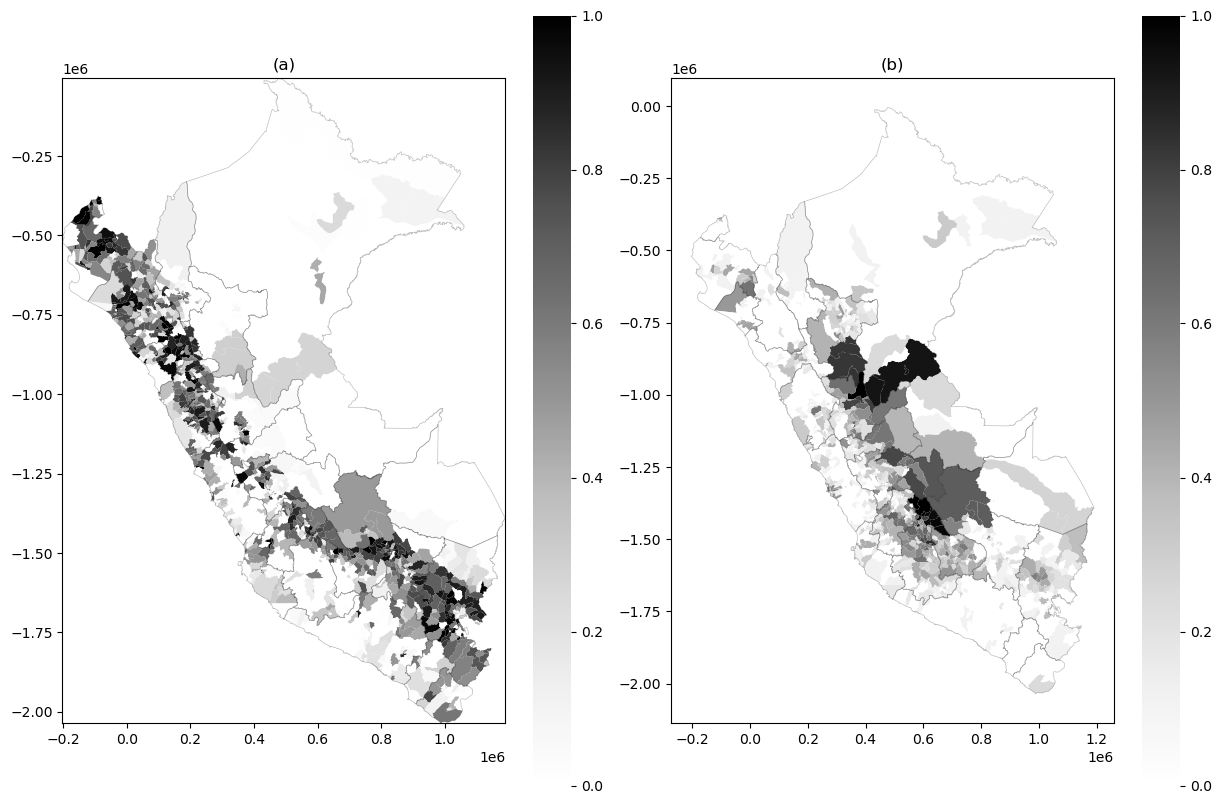

In [12]:
#Figura 2

#Creamos el objeto de la figura y especificamos el número de filas y columnas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# Configuramos límites de los ejes para los dos subgráficos
x_min, x_max = df1.total_bounds[0], df1.total_bounds[2]
y_min, y_max = df1.total_bounds[1], df1.total_bounds[3]

#Ajustamos los ejes de acuerdo a los límites establecidos
axes[0].set_aspect('equal')
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[1].set_aspect('equal')

#Incluimos las capas, los componentes del mapa de calor y el eje de la figura de la izquierda (Figura 2.1)
departamentos.boundary.plot(ax=axes[0], color='black', edgecolor='black', linewidth=0.5, alpha=0.25)
df1.plot(ax=axes[0], column='tierras', cmap='Greys', linewidth=0.5, legend=False)
axes[0].set_title('(a)') #Lo titulamos "(a)" como en el paper


#Incluimos las capas, los componentes del mapa de calor y el eje de la figura de la derecha (Figura 2.2)
departamentos.boundary.plot(ax=axes[1], color='black', edgecolor='black', linewidth=0.5, alpha=0.25)
df1.plot(ax=axes[1], column='violencia', cmap='Greys', linewidth=3, legend=False)
axes[1].set_title('(b)') #Lo titulamos "(b)" como en el paper

#Creamos los objetos cmap para la barra de color
cmap1 = cm.get_cmap('Greys') 
cmap2 = cm.get_cmap('Greys')

# Creaamos las barras de color de cada subgráfico
cb1 = plt.colorbar(cm.ScalarMappable(cmap=cmap1), ax=axes[0])
cb2 = plt.colorbar(cm.ScalarMappable(cmap=cmap2), ax=axes[1])

cb1.outline.set_visible(False)
cb2.outline.set_visible(False)

# Ajustamos el espaciado horizontal entre los subgráficos
plt.subplots_adjust(wspace=0.1)

#Mostramos la figura
plt.show()
